## Task: image(Ideal Pattern)-to-image(Optimized Mask) translation by using UNet

predicting the optimized intensity (or presence/absence) of each pixel in the mask. This makes the task more akin to regression or direct pixel-wise transformation, where each pixel's output is a continuous value representing its optimized state.

In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

class LithographyDataset(Dataset):
    def __init__(self, pattern_dir, mask_dir, transform=None):
        self.pattern_dir = pattern_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.patterns = [x for x in os.listdir(pattern_dir) if x.endswith('.png') or x.endswith('.jpg')]
        self.pattern_to_mask = {x: x.replace('.png', 'OPC.png').replace('.jpg', 'OPC.jpg') for x in self.patterns}

    def __len__(self):
        return len(self.patterns)

    def __getitem__(self, idx):
        pattern_filename = self.patterns[idx]
        mask_filename = self.pattern_to_mask[pattern_filename]
        pattern_path = os.path.join(self.pattern_dir, pattern_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        pattern = Image.open(pattern_path).convert('L')  # Convert to grayscale
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            pattern = self.transform(pattern)
            mask = self.transform(mask)

        return pattern, mask

pattern_dir = 'ganopc-data/target/images'
mask_dir    = 'ganopc-data/mask/images'

transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5]) # output values are in [-1, 1]
])

# Initialize your dataset with this transformation
full_dataset = LithographyDataset(pattern_dir, mask_dir, transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))
test_size = val_size = int(0.1 * len(full_dataset))
remainder = len(full_dataset) - (train_size + test_size + val_size)
test_size += remainder  # Adjust test set size to account for rounding
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

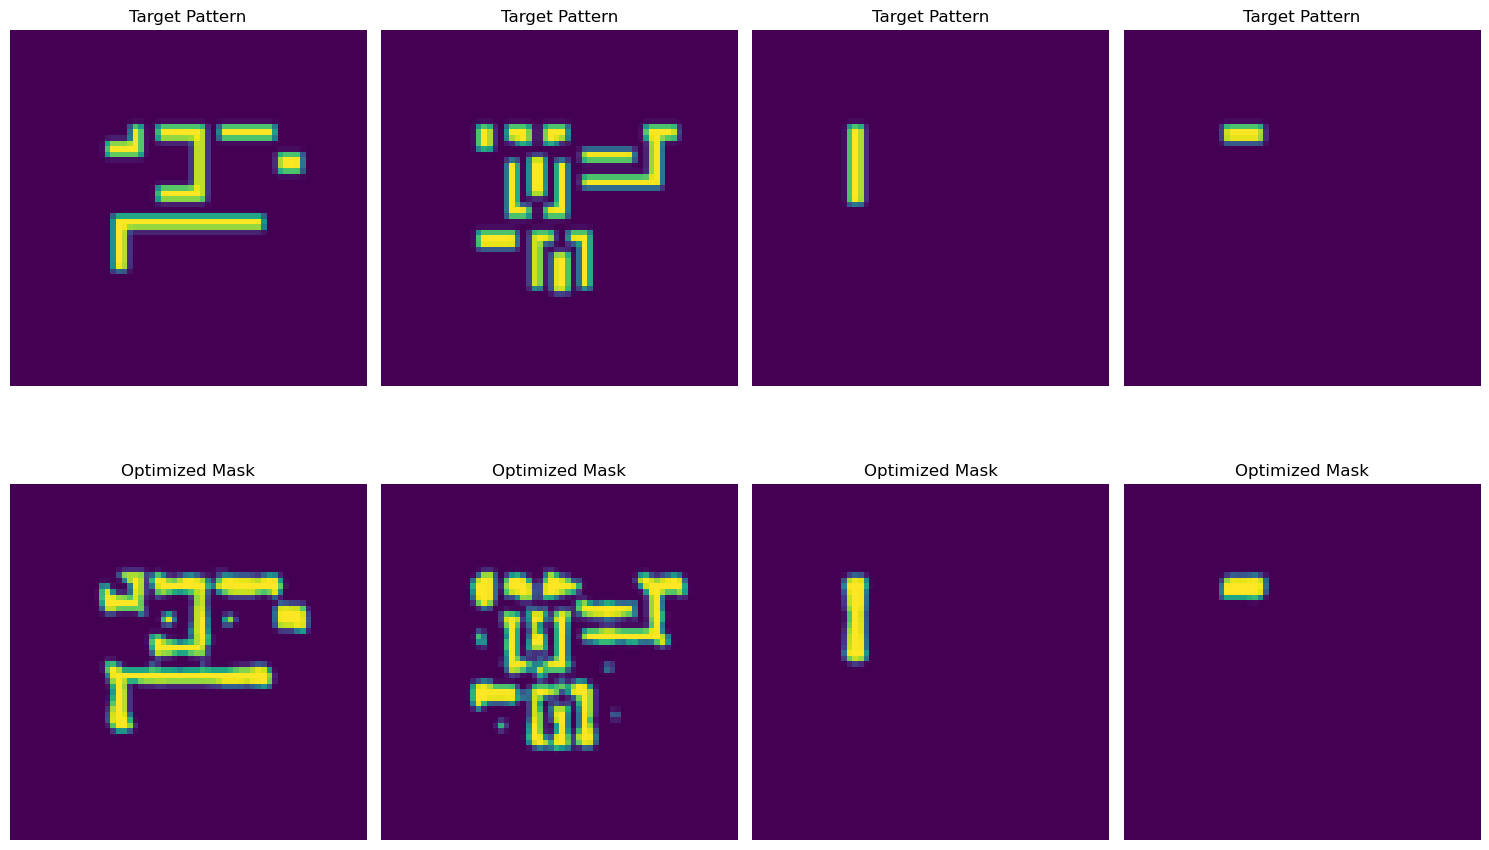

In [2]:
def plot_images_grid(images, titles, n_rows=3, n_cols=4, figsize=(15, 10)):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for row in range(n_rows):
        for col in range(n_cols):
            if col < len(images[row]):
                img = images[row][col].numpy().transpose((1, 2, 0))
                axs[row, col].imshow(img)
                axs[row, col].set_title(titles[row])
                axs[row, col].axis('off')
            else:
                axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

def visualize_batch(dataloader):
    dataiter = iter(dataloader)
    targets, masks = next(dataiter)
    n_display = min(4, len(masks))  # Display up to 4 images from the batch
    images_to_plot = [targets[:n_display], masks[:n_display]]
    titles = ['Target Pattern', 'Optimized Mask']
    plot_images_grid(images_to_plot, titles, n_rows=2, n_cols=n_display)

visualize_batch(train_loader)

In [4]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = Down(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = Down(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = Down(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        #self.final_activation = nn.Sigmoid()  # Only if your output values are in [0, 1]
        self.final_activation = nn.Tanh()  # Only if your output values are in [-1, 1]
        

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.final_activation(logits)  # Apply sigmoid
    

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * inputs.size(0)

        train_loss = running_loss_train / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        running_loss_val = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)

        val_loss = running_loss_val / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered. Stopping training.')
                break

        scheduler.step()  # Update the learning rate

    model.load_state_dict(best_model_wts)
    return train_losses, val_losses

In [7]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Epoch 1/25, Train Loss: 0.1175, Validation Loss: 0.0353
Epoch 2/25, Train Loss: 0.0271, Validation Loss: 0.0201
Epoch 3/25, Train Loss: 0.0174, Validation Loss: 0.0143
Epoch 4/25, Train Loss: 0.0130, Validation Loss: 0.0111
Epoch 5/25, Train Loss: 0.0104, Validation Loss: 0.0094
Epoch 6/25, Train Loss: 0.0090, Validation Loss: 0.0084
Epoch 7/25, Train Loss: 0.0080, Validation Loss: 0.0077
Epoch 8/25, Train Loss: 0.0074, Validation Loss: 0.0072
Epoch 9/25, Train Loss: 0.0069, Validation Loss: 0.0067
Epoch 10/25, Train Loss: 0.0065, Validation Loss: 0.0064
Epoch 11/25, Train Loss: 0.0063, Validation Loss: 0.0063
Epoch 12/25, Train Loss: 0.0062, Validation Loss: 0.0062
Epoch 13/25, Train Loss: 0.0062, Validation Loss: 0.0062
Epoch 14/25, Train Loss: 0.0061, Validation Loss: 0.0062
Epoch 15/25, Train Loss: 0.0061, Validation Loss: 0.0061
Epoch 16/25, Train Loss: 0.0060, Validation Loss: 0.0061
Epoch 17/25, Train Loss: 0.0060, Validation Loss: 0.0060
Epoch 18/25, Train Loss: 0.0059, Validat

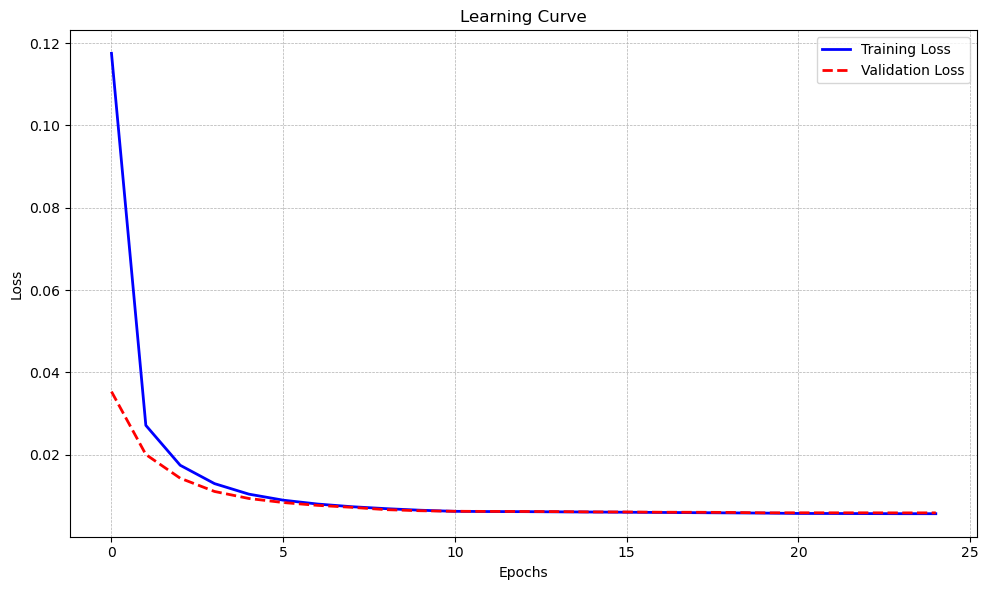

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1).to(device)
criterion = nn.MSELoss() # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5)


# Plot the learning curve
plot_learning_curve(train_losses, val_losses)

In [9]:
model_path = 'unet_lithography_model.pth'
torch.save(model.state_dict(), model_path)

In [13]:
def evaluate_model(model, test_loader, criterion):
    model.eval() 
    total_loss = 0.0
    
    # Determine the device the model is on
    device = next(model.parameters()).device
    
    with torch.no_grad():  # No need to track gradients for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
    
    print(f'Test Loss (L2 Metric): {total_loss / len(test_loader.dataset):.4f}')

evaluate_model(model, test_loader, nn.MSELoss())

Test Loss (L2 Metric): 0.0059


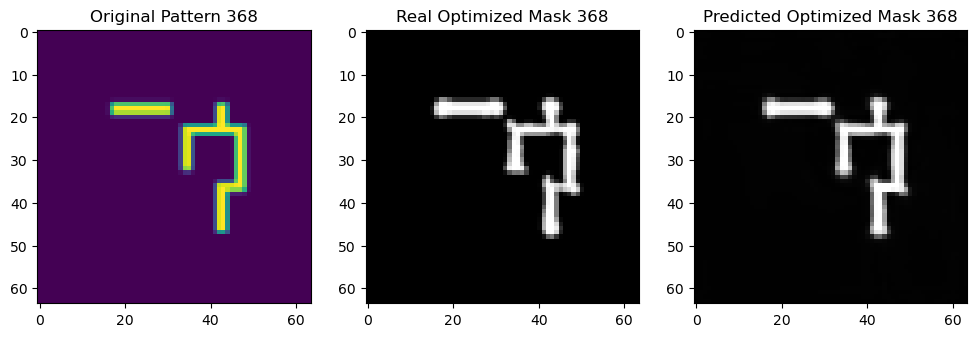

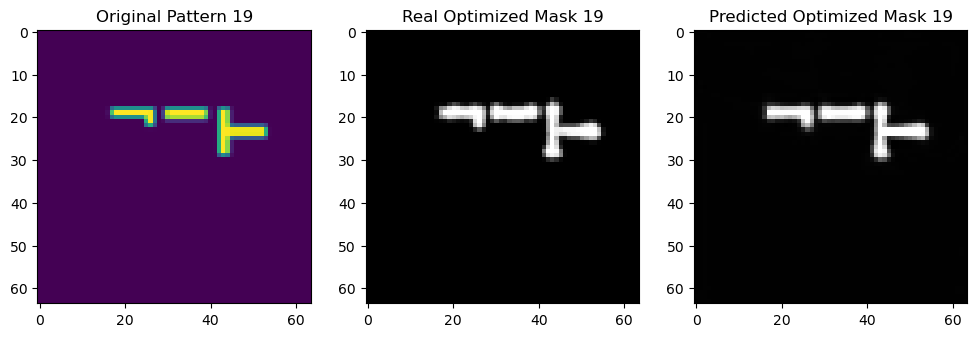

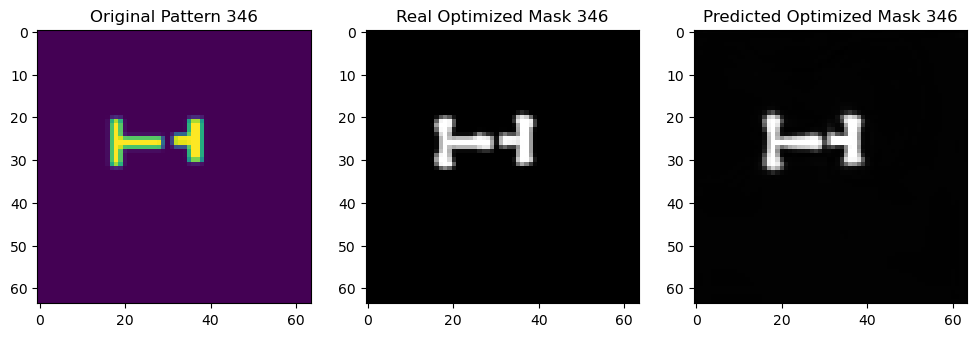

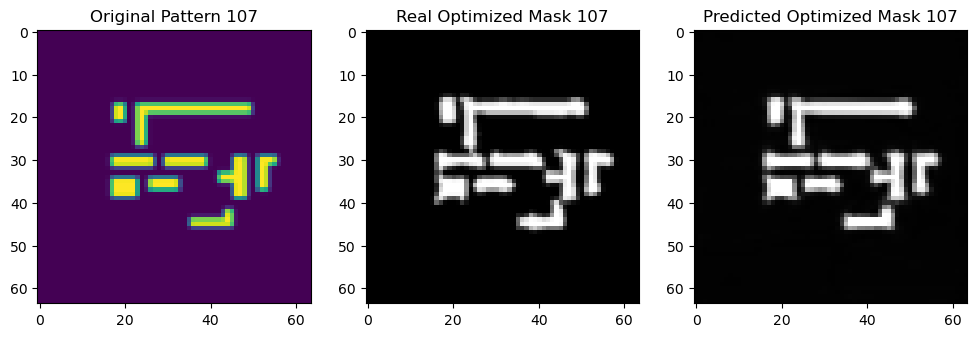

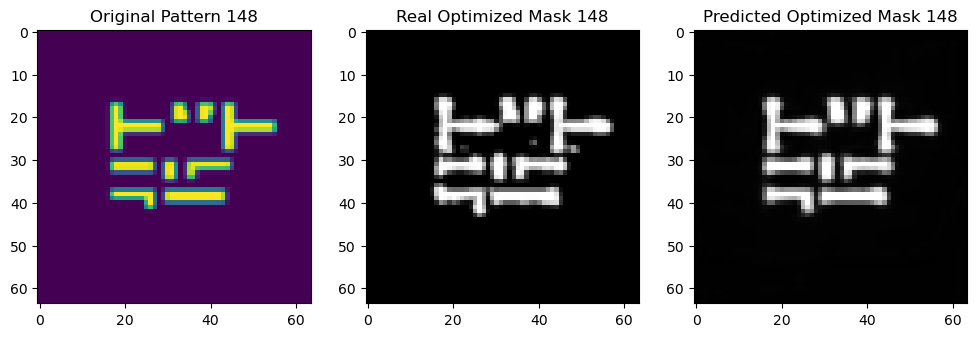

In [14]:
import random

def compare_masks(model, dataset, num_samples, device='cuda'):
    model.to(device)
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        pattern, real_mask = dataset[idx]
        pattern = pattern.unsqueeze(0).to(device)  # Add batch dimension
        real_mask = real_mask.to(device)
        
        with torch.no_grad():
            optimized_mask = model(pattern)

        pattern = pattern.squeeze(0).cpu()  # Remove batch dimension and move to CPU for plotting
        optimized_mask = optimized_mask.squeeze(0).cpu()
        real_mask = real_mask.cpu()

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(pattern.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[0].set_title(f'Original Pattern {idx}')
        axes[1].imshow(real_mask.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        axes[1].set_title(f'Real Optimized Mask {idx}')
        axes[2].imshow(optimized_mask.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        axes[2].set_title(f'Predicted Optimized Mask {idx}')
        plt.show()

compare_masks(model, test_dataset, num_samples=5, device='cuda')